In [1]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from prophet import Prophet
from datetime import datetime

In [2]:
# Read csv file
df = pd.read_csv("sales_data.csv", encoding='ISO-8859-1')

In [3]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [4]:
# Drop null values in Customer id
df.dropna(subset=['CustomerID'], inplace=True)

In [5]:
# new column TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [6]:
# Filter the columns
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df = df.drop_duplicates()

In [7]:
df.dtypes #check dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
TotalPrice     float64
dtype: object

In [8]:
# Datatype conversion
df['CustomerID'] = df['CustomerID'].astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [9]:
# provides the eom date values
monthly_sales = df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum()

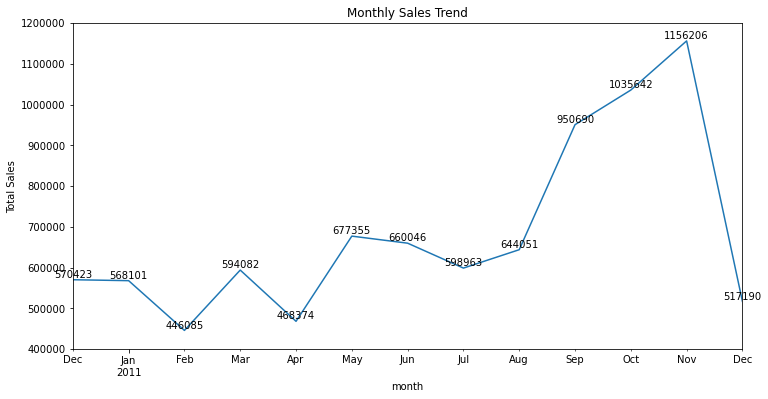

In [10]:
#Plotting the monthly sales

import matplotlib.pyplot as plt #plotting library

plt.figure(figsize=(12, 6)) # figure size
monthly_sales.plot(title='Monthly Sales Trend') # title
plt.xlabel('month') # x-axis
plt.ylabel('Total Sales') # y-axis

# Set the y-axis ticks to rounded values
y_ticks = plt.gca().get_yticks()  # Get current y-axis tick positions
plt.yticks(y_ticks, [f'{int(y)}' for y in y_ticks])  # Round each tick to an integer

# Optional: Annotate each data point with its rounded y-value (Total Sales)
for date, sales in monthly_sales.items():
    plt.text(date, sales, f'{round(sales)}', ha='center', va='bottom')

plt.show()



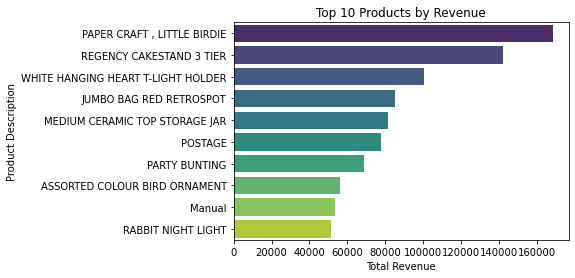

In [11]:
#plot Top 10 products by revenue

top_products = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10) # Group by Description
# Using sns module for plotting barplot
sns.barplot(y=top_products.index, x=top_products.values, palette='viridis')
plt.title('Top 10 Products by Revenue') # Chart title
plt.xlabel('Total Revenue') # x-axis
plt.ylabel('Product Description') # y-axis
plt.show() # To Display the chart

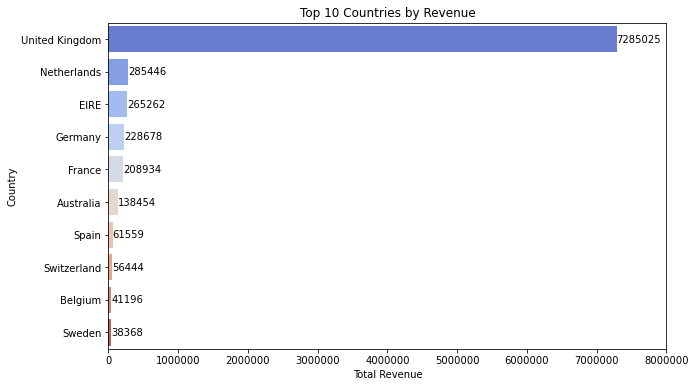

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total sales by country and take the top 10 countries
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

# Plot the data using a horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(y=country_sales.index, x=country_sales.values, palette='coolwarm')

# Set x-axis ticks to rounded values for better readability
x_ticks = plt.gca().get_xticks()  # Get current x-axis tick positions
plt.xticks(x_ticks, [f'{int(x)}' for x in x_ticks])  # Round each tick to an integer

# Optional: Annotate each bar with the total revenue
for index, sales in enumerate(country_sales.values):
    plt.text(sales, index, f'{round(sales)}', va='center', ha='left')

plt.title('Top 10 Countries by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Country')
plt.show()


In [18]:
# Calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'TotalPrice': 'sum'                                       # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Score RFM metrics
rfm['R'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# Combine RFM score
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# Segment Customers based on RFM Score
def segment_customer(df):
    if df['RFM_Score'] == '555':
        return 'Champions'
    elif df['RFM_Score'][0] == '5':
        return 'Loyal Customers'
    elif df['RFM_Score'] in ['311', '411', '511']:
        return 'At Risk'
    elif df['RFM_Score'][0] == '1':
        return 'Lost Customers'
    else:
        return 'Others'

rfm['Customer_Segment'] = rfm.apply(segment_customer, axis=1)

# View final RFM table
print(rfm.head())

            Recency  Frequency  Monetary  R  F  M RFM_Score Customer_Segment
CustomerID                                                                  
12346.0         326          1  77183.60  1  1  5       115   Lost Customers
12347.0           2          7   4310.00  5  5  5       555        Champions
12348.0          75          4   1797.24  2  4  4       244           Others
12349.0          19          1   1757.55  4  1  4       414           Others
12350.0         310          1    334.40  1  1  2       112   Lost Customers


In [33]:
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
rfm_new = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm_new.columns = ['Recency', 'Frequency', 'Monetary']


In [17]:
rfm_new

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


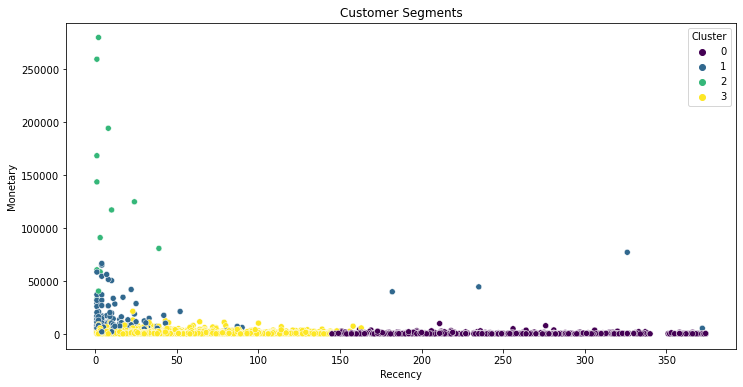

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_new)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_new['Cluster'] = kmeans.fit_predict(rfm_scaled)
# Visualize clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm_new, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

In [21]:
monthly_data = df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum().reset_index()
monthly_data.columns = ['ds', 'y'] # ds- date,y- sales
print(monthly_data)

           ds            y
0  2010-12-31   570422.730
1  2011-01-31   568101.310
2  2011-02-28   446084.920
3  2011-03-31   594081.760
4  2011-04-30   468374.331
5  2011-05-31   677355.150
6  2011-06-30   660046.050
7  2011-07-31   598962.901
8  2011-08-31   644051.040
9  2011-09-30   950690.202
10 2011-10-31  1035642.450
11 2011-11-30  1156205.610
12 2011-12-31   517190.440


In [60]:
# Prophet model for future forecasting

21:10:06 - cmdstanpy - INFO - Chain [1] start processing
21:10:06 - cmdstanpy - INFO - Chain [1] done processing


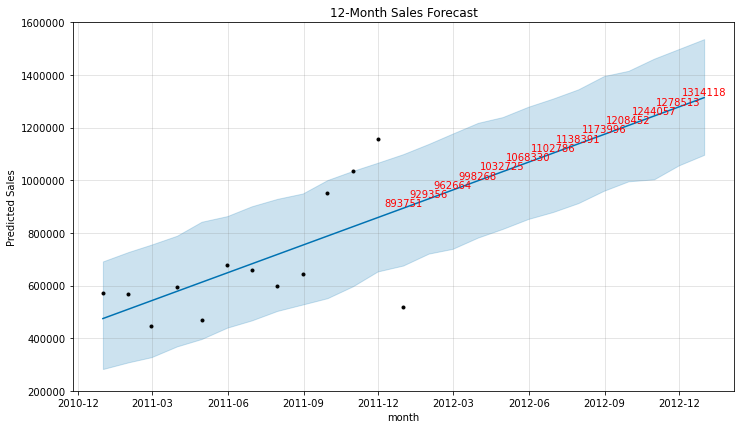

In [32]:

model = Prophet()
model.fit(monthly_data) #Fits the model to your time series data

future = model.make_future_dataframe(periods=12, freq='M') # Generates a DataFrame with dates for the next 12 months
forecast = model.predict(future) #Predicts future values based on the trained model

# Plot forecast
model.plot(forecast)
plt.title('12-Month Sales Forecast')
plt.xlabel('month')
plt.ylabel('Predicted Sales')

# Set y-axis ticks to rounded integer values
y_ticks = plt.gca().get_yticks()
plt.yticks(y_ticks, [int(y) for y in y_ticks])

for i in range(len(forecast)):
    if forecast['ds'][i] >= monthly_data['ds'].max():  # Only annotate future predictions
        plt.text(forecast['ds'][i], forecast['yhat'][i], f"{int(forecast['yhat'][i])}", 
                 ha='center', va='bottom', fontsize=10, color='red')
plt.show()


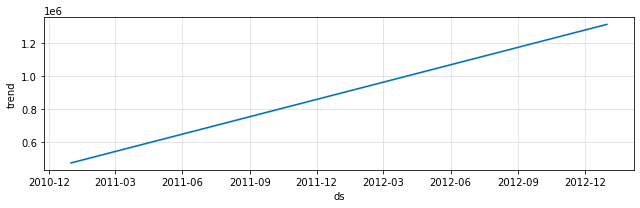

In [29]:
model.plot_components(forecast)
plt.show()
